# Quick analyzer of wether an object is visible from OT and when
Write object name, RA and DEC.

In [1]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as ticker 
import matplotlib.patheffects as PathEffects
import numpy as np

from astropy.coordinates import get_sun, get_body, EarthLocation, Angle, SkyCoord, AltAz
from astropy.time import Time
import astropy.units as u
import datetime
from astral import Observer, sun

In [2]:
def object_visibility(obj_name: str,
                      RA: str,
                      DEC: str,
                      location: str = 'Observatorio del Teide',
                      init_start_date = True,
                      n_days = 365,
                      moon = False,
                      angular_distance = False
                      ):
    """Function to visualize RA of object vs Sun and Moon from an observatory

    Parameters
    -----------
    obj_name : str
        Name of the object to observe

    RA : str
        Right ascension of the object in ``str`` format compatible with astropy.coordinates.Angle
    
    DEC : str
        Declination of the object in ``str`` format compatible with astropy.coordinates.Angle
    
    location : str
        Name of the observation site. To check available places, run ``EarthLocation.get_site_names()``
    
    init_start_date : True / datetime
        Start date for the plot in ``YYYY-MM-DD`` format. If True, today is considered

    n_days : int
        Number of days to display
    """

    # Initial date
    if init_start_date == True: start_date = datetime.date.today()
    else: start_date = datetime.date.fromisoformat(init_start_date)

    # Create list of datetime.datetime objects (midnight UTC)
    datetimes = [
        datetime.datetime.combine(start_date + datetime.timedelta(days=i), datetime.time(0, 0))
        for i in range(n_days)
    ]

    # Convert to Astropy Time objects
    times = Time(datetimes)

    # Compute the Sun's coordinates for each date
    sun_coords = get_sun(times)
    # Convert input RA and DEC to angle
    obj_RA = Angle(RA).to(u.deg)
    obj_DEC = Angle(DEC)
    obj_coords = SkyCoord(obj_RA, obj_DEC, frame = 'icrs')
    obj_gcrs = obj_coords.transform_to('gcrs')


    # plotting
    fig, ax = plt.subplots(num =1)

    ax.plot(times.datetime, sun_coords.ra.copy(), color = 'tab:blue', label = 'Sun')
    if moon:
        # Compute the Moon's cordinates for each date from OT location
        loc = EarthLocation.of_site(location)
        moon_coords = get_body('moon', time = times, location = loc)
        ax.plot(times.datetime, moon_coords.ra.copy(), color = 'tab:red', label = 'Moon')
    if angular_distance:
        sun_icrs = sun_coords.transform_to('icrs')
        separation = obj_coords.separation(sun_icrs).deg
        # sep_gcrs = obj_gcrs.separation(sun_coords).deg
        ax.plot(times.datetime, separation, label = 'angular separation ICRS')
        # ax.plot(times.datetime, sep_gcrs, label = 'angular separation GCRS')
    # ax.fill_between(times.datetime, sun_coords.ra.copy()-90*u.deg, sun_coords.ra.copy()+90*u.deg,
    #                 alpha = 0.3, color = 'tab:blue', label = 'Sun $\\pm 90$º')
    
    ax.plot(times.datetime, obj_RA*np.ones_like(times), color = 'tab:orange', label = obj_name) 

    # ax.axvline(times.datetime[i_1], ls='dashed', color='gray', alpha =0.8)
    # ax.axvline(times.datetime[i_2], ls='dashed', color='gray', alpha =0.8)
    # ax.plot(times.datetime[i_1],  obj_RA_array[0].value, marker='+', color ='black')
    # ax.plot(times.datetime[i_2],  obj_RA_array[0].value, marker='+', color ='black')
    # ax.text(times.datetime[i_1],  obj_RA_array[0].value+20, str(times.datetime[i_1].year)+'-'+str(times.datetime[i_1].month)+'-'+str(times.datetime[i_1].day))
    # ax.text(times.datetime[i_2],  obj_RA_array[0].value-20, str(times.datetime[i_2].year)+'-'+str(times.datetime[i_2].month)+'-'+str(times.datetime[i_2].day))

    ax.set_xlabel('Date')
    ax.set_ylabel('Right Ascension [º]')
    ax.set_xlim(times.datetime[0], times.datetime[-1])
    ax.set_ylim(0,360)
    ax.tick_params('x', rotation = 45)
    ax.grid()
    ax.legend()
    # plt.savefig('observation'+obj_name+'.png', dpi=200)

def staralt(obj_name,
            date: str,
            RA = None,
            DEC = None,
            altogether: bool = False,
            altitude = None,
            location: str = 'Observatorio del Teide',
            moon : bool = True,
            culmen = False
            ):
    """Function to visualize elevation vs time from an observatory.

    Parameters
    -----------
    obj_name : str
        Name of the object to observe

    date : str
        Observation date
    
    RA : str
        Right ascension of the object in ``str`` format compatible with astropy.coordinates.Angle
    
    DEC : str
        Declination of the object in ``str`` format compatible with astropy.coordinates.Angle

    altogether : bool (optional)
        ``False`` to give data in obj_name, RA, DEC separately. ``True`` to give data in a single string ``name RAh DECd``
    
    altitude : float / list of floats (optional)
        If given, display the time at wich object gets to certain altitude.
    
    location : str (optional)
        Name of the observation site. To check available places, run ``EarthLocation.get_site_names()``. Observatorio Teide automatically

    moon : bool (optional)
        Wether to display moon position or not.
    """
    print('\nObservation night: ', date)
    # Observation date and next day
    date_obs = datetime.date.fromisoformat(date)
    date_next = date_obs + datetime.timedelta(days=1)
    # Location and astronomical night relevant times
    loc = EarthLocation.of_site(location)
    observer = Observer(loc.lat.deg, loc.lon.deg, loc.height.value)
    s1, s2 = sun.sun(observer, date_obs, 18), sun.sun(observer, date_next, 18)
    sunset, dusk, sunrise, dawn = s1['sunset'], s1['dusk'], s2['sunrise'], s2['dawn']
    total_minutes = int((sunrise - sunset).total_seconds()/60)
    times_list = [sunset + datetime.timedelta(minutes=i) for i in range(total_minutes)]
    times = Time(times_list)

    altaz_frame = AltAz(obstime = times, location = loc)

    if altitude != False: alt_dict = {}
    if culmen: cul_dict = {}

    if moon:
            moon_coords = get_body('moon', time = times, location = loc)
            moon_alt = moon_coords.transform_to(altaz_frame).alt.degree
            moon_radec = SkyCoord(ra = moon_coords.ra, dec = moon_coords.dec, frame = 'icrs', unit = u.deg)
    # If name, RA, DEC all in one string with spaces
    if altogether:
        if type(obj_name) == str:
            obj_name, RA, DEC = obj_name.split()
        else:
            objs, RA, DEC = [], [], []
            for i, obj in enumerate(obj_name):
                objs.append(obj.split()[0])
                RA.append(obj.split()[1])
                DEC.append(obj.split()[2])
            obj_name = objs
    # Managing of multiple objects
    if type(obj_name) == str:
        obj_list, RA_list, DEC_list = [obj_name], [RA], [DEC]
    else:
        obj_list, RA_list, DEC_list = obj_name, RA, DEC
    n_obj = len(obj_name)
    fig, ax = plt.subplots()

    for k, (obj_name, RA, DEC) in enumerate(zip(obj_list, RA_list, DEC_list)):
        obj_RA = Angle(RA).to(u.deg)
        obj_DEC = Angle(DEC)
        obj_coords = SkyCoord(obj_RA, obj_DEC, frame = 'icrs')
        # Obtain altitud for the object at each time
        obj_altaz = obj_coords.transform_to(altaz_frame)
        obj_alt = obj_altaz.alt.degree

        if culmen:
            cul_dict[obj_name] = (times[np.argmax(obj_alt)], np.max(obj_alt))

        # Object and moon plot
        if moon:
            if k==0: ax.plot(times.datetime, moon_alt, ls = 'dashed', color = 'gray', label = 'Moon')
            sep = obj_coords.separation(moon_radec).deg
            for i in range(len(times)//120):
                j=i*120
                if obj_alt[j] > 10:
                    text = ax.text(times.datetime[j], obj_alt[j], '%.0i$^\\circ$'%(sep[j]), color = plt.get_cmap('tab10')(k))
                    text.set_path_effects([PathEffects.withStroke(linewidth=3, foreground='white')])
        ax.plot(times.datetime, obj_alt, label = obj_name)

        # Calculate time of a given altitude
        if altitude != None:
            if type(altitude) != list:
                x_num = mdates.date2num(times.datetime)
                alt_diff = obj_alt-altitude
                sign_change = np.where(np.diff(np.sign(alt_diff))!=0)[0]
                obj_alt_time = []
                for idx in sign_change:
                    x0, x1 = x_num[idx], x_num[idx + 1]
                    y0, y1 = alt_diff[idx], alt_diff[idx + 1]
                    if y1 != y0:
                        x_inter_num = x0 - y0 * (x1 - x0) / (y1 - y0)
                        obj_alt_time.append(mdates.num2date(x_inter_num))  # Convert back to datetime
                    else:
                        obj_alt_time.append(times[idx])
                alt_dict[obj_name] = obj_alt_time
                # alt_times.append()
                # alt_i = np.argmin(abs(obj_alt-altitude))
                # alt_times.append(times.datetime[alt_i])
                if k==0: ax.axhline(altitude, color = 'gray', ls = 'dashdot')
                # text = ax.text(times.datetime[alt_i], obj_alt[alt_i], str(times.datetime[alt_i].time().hour)+':'+str(times.datetime[alt_i].time().minute),
                #                color = plt.get_cmap('tab10')(k))
                # text.set_path_effects([PathEffects.withStroke(linewidth=3, foreground='white')])
                # ax.scatter(times.datetime[alt_i], obj_alt[alt_i], marker = '+', color = plt.get_cmap('tab10')(k))

            # if type(altitude) == list:
            #     al

    # dusk and dawn
    ax.axvline(dusk, ls = 'dotted', color = 'black', alpha = 0.6)
    ax.axvline(dawn, ls = 'dotted', color = 'black', alpha = 0.6)
    ax.fill_between([sunset, dusk], 90, color = 'gray', alpha = 0.5)
    ax.fill_between([dawn, sunrise], 90, color = 'gray', alpha = 0.5)
    ax.axvline(date_next, ls = 'solid', color = 'black', alpha = 0.6, zorder = 1)

    # axis and tick locators
    ax.set_xlim(times.datetime[0], times.datetime[-1])
    ax.xaxis.set_major_locator(mdates.HourLocator(interval=2))
    ax.xaxis.set_minor_locator(mdates.HourLocator(interval=1))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    ax.set_xlabel('Hour [UT]')
    #
    ax.set_ylabel('Altitude [$^\\circ$]')
    ax.set_ylim(10, 90)
    ticks_alt = np.linspace(10, 90, 9)  # e.g., every 15 degrees
    ax.set_yticks(ticks_alt)
    # ax.yaxis.set_minor_locator(ticker.MultipleLocator(5))
    #
    ax.grid(True, axis = 'x', which = 'minor', ls = 'dashed')
    ax.grid(True, axis = 'x', which = 'major')
    ax.grid(True, axis = 'y', which = 'minor', ls = 'dashed')
    ax.grid(True, axis = 'y', which = 'major')

    ax.set_title('Altitude of object %s\nNight of %s at %s'%(obj_name, date, location))
    plt.legend()

    print('Astronominal dusk: ', f'{dusk.time().hour:02d}:{dusk.time().minute:02d}')
    print('Astronomical dawn: ', f'{dawn.time().hour:02d}:{dawn.time().minute:02d}')
    print()
    if altitude != None:
        print('Objects crossing specified altitude: ', altitude)
        for k, obj in enumerate(obj_list):
            time_of_altitude = [f'{t.time().hour:02d}:{t.time().minute:02d}' for t in alt_dict[obj]]
            print(' - ', obj, '  ', time_of_altitude)
    
    if culmen:
        print('Objects culmination time:')
        for k, obj in enumerate(obj_list):
            print(' - ', obj, '  ', f'{cul_dict[obj][0].datetime.time().hour:02d}:{cul_dict[obj][0].datetime.time().minute:02d} - {cul_dict[obj][1]:.2f}º')
    
    def transf(y): return 1/np.sin(y*np.pi/180)
    def transf_i(y): return np.arcsin(1/y)*180/np.pi
    ax2 = ax.secondary_yaxis('right', functions = (transf, transf_i))
    ax2.set_ylim(transf(10), transf(90))
    ticks_airmass = transf(ticks_alt)#ax.get_yticks()
    ax2.set_yticks(ticks_airmass)
    ax2.set_yticklabels([f"{val:.2f}" for val in ticks_airmass])
    ax2.set_ylabel('Airmass')

    


Observation night:  2025-12-25
Astronominal dusk:  19:48
Astronomical dawn:  06:24

Objects crossing specified altitude:  40
 -  ZTF    ['22:07', '06:03']
 -  DESI    ['20:51']

Observation night:  2025-12-28
Astronominal dusk:  19:50
Astronomical dawn:  06:25

Objects crossing specified altitude:  40
 -  ZTF    ['21:55', '05:51']
 -  DESI    ['20:39']

Observation night:  2025-12-30
Astronominal dusk:  19:51
Astronomical dawn:  06:26

Objects crossing specified altitude:  40
 -  ZTF    ['21:47', '05:43']
 -  DESI    ['20:31']


/var/folders/lp/gmwtz0k15l9131lfg2fd97bh0000gn/T/ipykernel_4148/3112593567.py:263: RuntimeWarning: divide by zero encountered in divide
  def transf_i(y): return np.arcsin(1/y)*180/np.pi
/var/folders/lp/gmwtz0k15l9131lfg2fd97bh0000gn/T/ipykernel_4148/3112593567.py:263: RuntimeWarning: invalid value encountered in arcsin
  def transf_i(y): return np.arcsin(1/y)*180/np.pi


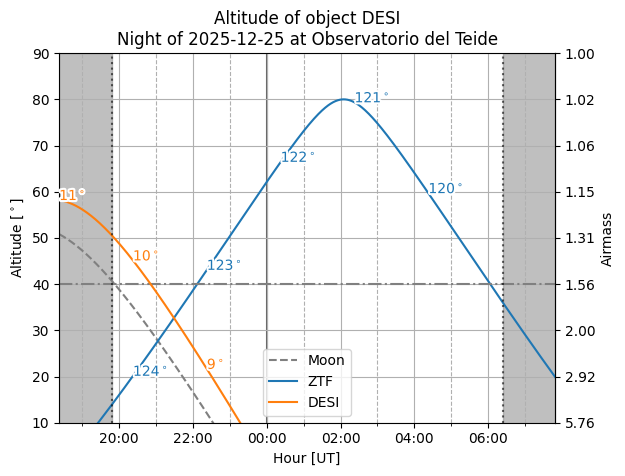

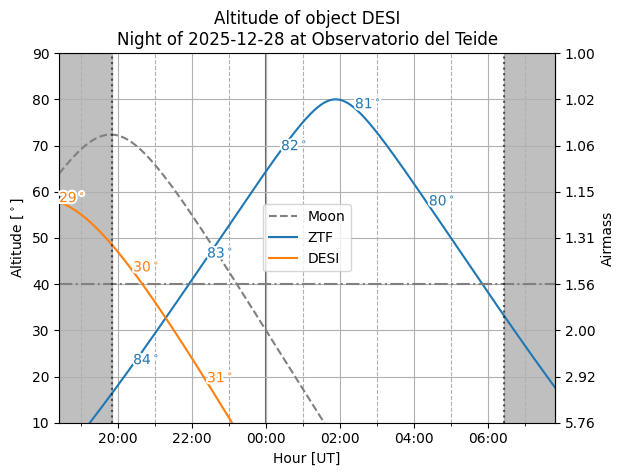

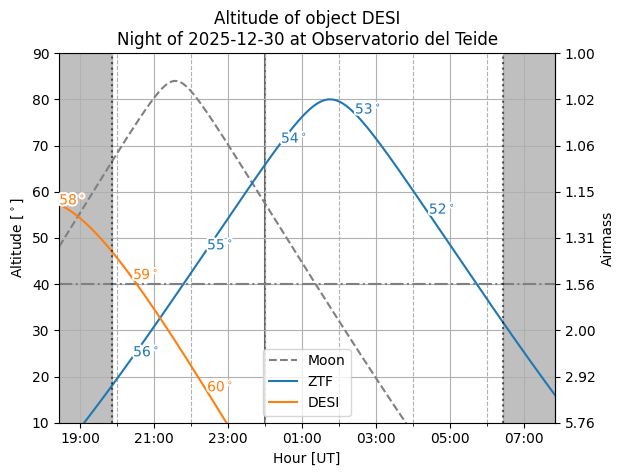

In [4]:
objects = [
    'ZTF 07:16:34h +38:21:14d',
           'DESI 23:21:23h -03:30:30d']
        #    'TOI-5571 07:07:58h +60:00:42d',
        #    'TOI-3767 04:37:57.15h +52:42:58.5d']

days = ['25', '28', '30']
for d in days:
    staralt(objects, '2025-12-'+d, altogether=True, altitude = 40, culmen=False)


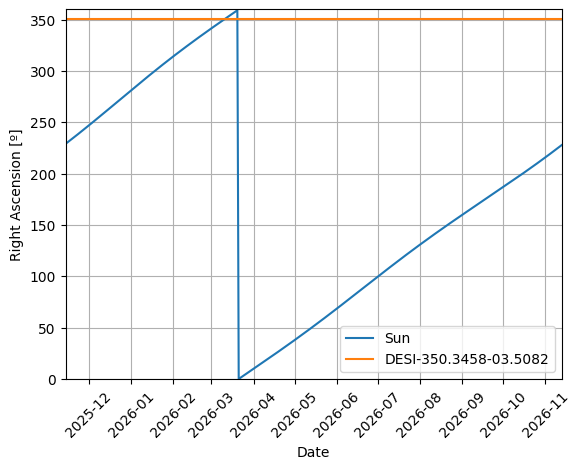

In [59]:
object_visibility('DESI-350.3458-03.5082',
                  '350.3458d',
                    '-03.5082d'
                  )

In [61]:
# String with object name
obj_name = 'DESI-350.3458-03.5082'
# RA in selected units 350.3458-03.5082
RA_hh_mm_ss = '07:16:34.500 hours'  # hour, min, sec
DEC_dd_mm_ss = '+38:21:08.11 deg' # deg, arcmin, arcsec
RA = '350.3458d'
DEC = '-03.5082d'


init_start_date = True #'2025-01-01' # if true, start date is today. If not true, insert string with YYYY-MM-DD for start date

n_days = 625  # more than one year



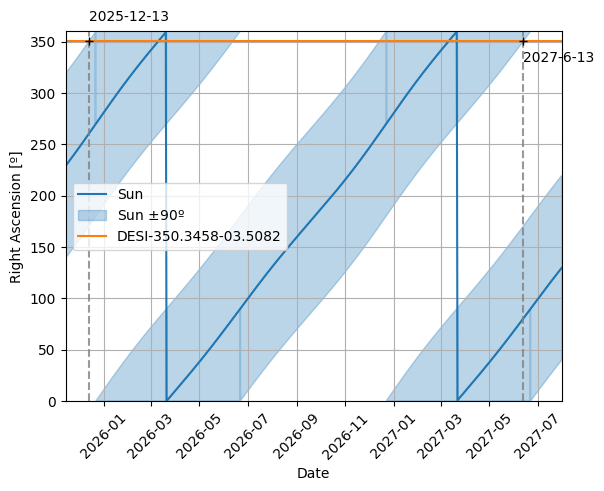

In [63]:
# --- Configuration ---
if init_start_date == True: start_date = datetime.date.today()
else: start_date = datetime.date.fromisoformat(init_start_date)

# Create list of datetime.datetime objects (midnight UTC)
datetimes = [
    datetime.datetime.combine(start_date + datetime.timedelta(days=i), datetime.time(0, 0))
    for i in range(n_days)
]

# Convert to Astropy Time objects
times = Time(datetimes)

# Compute the Sun's coordinates for each date
sun_coords = get_sun(times)
# Compute Moon cordinates for each date from OT location
location = EarthLocation.of_site('Observatorio del Teide')
moon_coords = get_body('moon', time = times, location = location)

# Convert input RA and DEC to angle
obj_RA = Angle(RA).to(u.deg)
obj_DEC = Angle(DEC)


# RA as continuous
sun_ra_cont = sun_coords.ra.copy()
i_0 = np.argmin(sun_ra_cont)
offset = np.concatenate((np.zeros(i_0), np.ones(int(n_days-i_0))))

sun_ra_cont = sun_ra_cont #+ offset * 360 * u.deg
sun_ra_cont_offset = sun_ra_cont + offset * 360 * u.deg

# DESI_ra = np.ones(n_days)*350.4458*u.deg
obj_RA_array = obj_RA * np.ones(n_days)

i_up_above = np.where(sun_ra_cont+90*u.deg>360*u.deg, 1, 0)
i_up_below = 1-i_up_above
i_lo_below = np.where(sun_ra_cont-90*u.deg < 0*u.deg, 1, 0)
i_lo_above = 1-i_lo_below

up_bound = sun_ra_cont+90*u.deg - 360*u.deg*i_up_above
lo_bound = sun_ra_cont-90*u.deg + 360*u.deg*i_lo_below

i_up_good = np.where(up_bound>sun_ra_cont, 0,1)
i_lo_good = np.where(lo_bound<sun_ra_cont, 0,1)
#index of times in which object appears and disappears
i_1 = np.argmin(abs(up_bound - obj_RA))
i_2 = np.argmin(abs(lo_bound - obj_RA))

# plotting
fig, ax = plt.subplots(num =1)

ax.plot(times.datetime, sun_ra_cont, color = 'tab:blue', label = 'Sun')

ax.fill_between(np.ma.array(times.datetime, mask = i_lo_good),
                np.ma.array((lo_bound).value, mask= i_lo_good), 
                sun_ra_cont.value, alpha = 0.3, color = 'tab:blue', label = 'Sun $\\pm 90$º')
ax.fill_between(np.ma.array(times.datetime, mask = 1-i_lo_good), 
                np.ma.array((lo_bound).value, mask= 1-i_lo_good), 
                360, alpha = 0.3, color = 'tab:blue')

ax.fill_between(np.ma.array(times.datetime, mask = i_up_good), 
                sun_ra_cont.value, 
                np.ma.array((up_bound).value, mask= i_up_good), alpha = 0.3, color = 'tab:blue')
ax.fill_between(np.ma.array(times.datetime, mask = 1-i_up_good),
                0,  
                np.ma.array((up_bound).value, mask= 1-i_up_good), alpha = 0.3, color = 'tab:blue')

ax.fill_between(np.ma.array(times.datetime, mask = 1-(1-i_up_good)*i_lo_good),
                0,
                sun_ra_cont.value, alpha = 0.3, color = 'tab:blue')
ax.fill_between(np.ma.array(times.datetime, mask = 1-(1-i_lo_good)*i_up_good),
                sun_ra_cont.value, 
                360, alpha = 0.3, color = 'tab:blue')

ax.plot(times.datetime, obj_RA_array, color = 'tab:orange', label = obj_name) 


ax.axvline(times.datetime[i_1], ls='dashed', color='gray', alpha =0.8)
ax.axvline(times.datetime[i_2], ls='dashed', color='gray', alpha =0.8)
ax.plot(times.datetime[i_1],  obj_RA_array[0].value, marker='+', color ='black')
ax.plot(times.datetime[i_2],  obj_RA_array[0].value, marker='+', color ='black')
ax.text(times.datetime[i_1],  obj_RA_array[0].value+20, str(times.datetime[i_1].year)+'-'+str(times.datetime[i_1].month)+'-'+str(times.datetime[i_1].day))
ax.text(times.datetime[i_2],  obj_RA_array[0].value-20, str(times.datetime[i_2].year)+'-'+str(times.datetime[i_2].month)+'-'+str(times.datetime[i_2].day))

ax.set_xlabel('Date')
ax.set_ylabel('Right Ascension [º]')
ax.set_xlim(times.datetime[0], times.datetime[-1])
ax.set_ylim(0,360)
ax.tick_params('x', rotation = 45)
ax.grid()
ax.legend()
# plt.savefig('observation'+obj_name+'.png', dpi=200)
